# This project is split in 4 parts:

## 1- Scrapping to get a database
## 2- Data processing and Analysis
## 3- Vectorization and model creation

In [1]:
################### libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import string

import nltk
porter_stemmer = nltk.stem.porter.PorterStemmer()
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer

stopw = list(ENGLISH_STOP_WORDS) #stopwords list

from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split as tts
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV as GSCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, f1_score, accuracy_score,  roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns

# 1- Web Scrapping

In [2]:
# user agents taken from WSite: https://developers.whatismybrowser.com/useragents/parse/?analyse-my-user-agent=yes#parse-useragent 
HEADERS = ({'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.102 Safari/537.36',
            'Accept-Language': 'en-US, en;q=0.5'})

In [3]:
#Functions to get a beautifulsoup variable from web page url
def get_data(url):
    r = requests.get(url, headers = HEADERS)
    return r.text

def html_code(url):
    htmldata = get_data(url)
    soup = BeautifulSoup(htmldata, 'html.parser')
    return soup

#product = ALEXA 1st GEN
url ='https://www.amazon.com/Amazon-Echo-Bluetooth-Speaker-with-Alexa-Black/product-reviews/B00X4WHP5E/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews'

In [4]:
#Example
soup = html_code(url)
print(soup)

<!DOCTYPE html>
<html class="a-no-js" data-19ax5a9jf="dingo" lang="en-us"><!-- sp:feature:head-start -->
<head><script>var aPageStart = (new Date()).getTime();</script><meta charset="utf-8"/>
<!-- sp:end-feature:head-start -->
<script type="text/javascript">var ue_t0=ue_t0||+new Date();</script>
<!-- sp:feature:cs-optimization -->
<meta content="on" http-equiv="x-dns-prefetch-control"/>
<link href="https://images-na.ssl-images-amazon.com" rel="dns-prefetch"/>
<link href="https://m.media-amazon.com" rel="dns-prefetch"/>
<link href="https://completion.amazon.com" rel="dns-prefetch"/>
<!-- sp:end-feature:cs-optimization -->
<script type="text/javascript">
window.ue_ihb = (window.ue_ihb || window.ueinit || 0) + 1;
if (window.ue_ihb === 1) {

var ue_csm = window,
    ue_hob = +new Date();
(function(d){var e=d.ue=d.ue||{},f=Date.now||function(){return+new Date};e.d=function(b){return f()-(b?0:d.ue_t0)};e.stub=function(b,a){if(!b[a]){var c=[];b[a]=function(){c.push([c.slice.call(arguments),e.

In [5]:
#GET customer Name
# customer names are under tag 'SPAN' with class='a-profile-name'
def customer_data(Soup):
    customer_list = []
    #create soup with reviews only
    Soup1 = Soup.find("div", {'class':'a-section a-spacing-none reviews-content a-size-base'})
    # removing profile names linked to shared pictures
    for a in Soup1.find_all("a", class_ = "a-profile cr-lightbox-customer-profile"):
        a.decompose()
    
    for item in Soup1.find_all("span", class_ = "a-profile-name"):
        customer_list.append(item.get_text())
    return customer_list

customers = customer_data(soup)
print(customers) #example

['Michael', 'Alex S', 'Michael Davis', 'Karla Harley', 'E. M. Foner', 'Ron', 'Mike Williams', 'Ludacris', 'Devlin', 'John Robinson']


In [6]:
# review found in span under span w/ class= 'a-size-base review-text review-text-content'
def customer_review(Soup):
    customer_list = []
    for item in Soup.find_all("span", class_ = "a-size-base review-text review-text-content"):
        customer_list.append(item.get_text())
    return customer_list

reviews = customer_review(soup)
print(reviews)

['\n\n  LOVE OUR NEW ECHO!  I have been watching the reviews online and checking with friends that have purchased the Echo to see how much they liked or disliked its features.  Last person I talked to went on and on about all the things there were using it for and that persuaded me it was time and Amazon Prime Day was the perfect opportunity to go for it.  Amazon did a fantastic job of creating this tubular info-taining command center!  There are so many cool and awesome things its able to do that I\'ll hit the highlights that work for our household.  First, we love that it follows your voice in the room (the circle lighting will show which direction it is \'listening\'), the speaker is wonderfully balanced, so whether listening to music, the news or to Alexa speaking, I have nothing but high marks for its sound quality, given its size.  Next, set up (after downloading the app to our iPhones) was quick, easy and very intuitive.  The more you look over the app, the more you will realize

In [7]:
# gets product info (product name, manufacturor and global rating of product)
def product_info(Soup):
    p_name = Soup.find("a", {'data-hook':'product-link'}).get_text()
    p_manufacturor = Soup.find("a", {'class':'a-size-base a-link-normal'}).get_text()
    p_rating = Soup.find("span", {'data-hook':'rating-out-of-text'}).get_text()
    p_rating = p_rating.split(' ')
    p_rating = p_rating[0]
    p_rating = float(p_rating)
    info_dict = { 'Name': p_name,
                'Manufacturor': p_manufacturor,
                'Rating': p_rating}
    return info_dict

p_info= product_info(soup)

In [8]:
# each url has a variable (i) number of pages containing reviews each page holds 10 reviews so if we want 1000 each we set i to 100
#one star comments
def get_url_neg_comments_from_page(page_number):
    neg_rev_url= 'https://www.amazon.com/Amazon-Echo-Bluetooth-Speaker-with-Alexa-Black/product-reviews/B00X4WHP5E/ref=cm_cr_arp_d_viewopt_sr?ie=UTF8&filterByStar=one_star&pageNumber=' + page_number + '&reviewerType=all_reviews&pageSize=10'
    return neg_rev_url

#5 stars comments
def get_url_pos_comments_from_page(page_number):
    pos_rev_url= 'https://www.amazon.com/Amazon-Echo-Bluetooth-Speaker-with-Alexa-Black/product-reviews/B00X4WHP5E/ref=cm_cr_arp_d_viewopt_sr?ie=UTF8&filterByStar=five_star&pageNumber=' + page_number + '&reviewerType=all_reviews&pageSize=10'
    return pos_rev_url

In [9]:
#get list of urls with certain length (2*input)
def get_soups(length):
    customers = []
    reviews = []
    ratings = []
    for i in range(length):
        p_url = get_url_pos_comments_from_page(str(i))
        n_url = get_url_neg_comments_from_page(str(i))
        for url in [p_url, n_url]:
            soup = html_code(url)
            customers.extend(customer_data(soup))
            reviews.extend(customer_review(soup))
            if url == p_url:
                pr = ['Positive'] * 10
                ratings.extend(pr)
            else:
                nr = ['Negative'] * 10
                ratings.extend(nr)
    return customers, reviews, ratings

cus, rev, rat = get_soups(100)

In [10]:
data = {'Prod name': p_info['Name'],
        'Prod Manufacturor': p_info['Manufacturor'],
        'Prod Rating': p_info['Rating'],
        'Reviewer Name': cus,
        'Review text': rev,
        'Review Rating': rat}

data = pd.DataFrame(data)
data

,Prod name,Prod Manufacturor,Prod Rating,Reviewer Name,Review text,Review Rating
0,Amazon Echo - Black (1st Generation),Amazon,4.5,Michael,\n\n LOVE OUR NEW ECHO! I have been watching...,Positive
1,Amazon Echo - Black (1st Generation),Amazon,4.5,Alex S,\n\n We have been using Echo since April 2015...,Positive
2,Amazon Echo - Black (1st Generation),Amazon,4.5,Michael Davis,\n\n I have been using advanced technology fo...,Positive
3,Amazon Echo - Black (1st Generation),Amazon,4.5,Karla Harley,\n\n I LOVE ALEXA! It's amazing how quickly y...,Positive
4,Amazon Echo - Black (1st Generation),Amazon,4.5,E. M. Foner,\n\n I'm a full-time writer who works at home...,Positive
...,...,...,...,...,...,...
1995,Amazon Echo - Black (1st Generation),Amazon,4.5,wat3456,\n\n I've had an echo dot for a few months no...,Negative
1996,Amazon Echo - Black (1st Generation),Amazon,4.5,Ariel Sandoval,\n\n Mostly useless. It can play music and re...,Negative
1997,Amazon Echo - Black (1st Generation),Amazon,4.5,Amazon Customer,\n\n Very disappointed about Echo's llifetime...,Negative
1998,Amazon Echo - Black (1st Generation),Amazon,4.5,J. Odam,\n\n The device is fine but the app is a comp...,Negative


# Data Processing and Analysis

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Prod name          2000 non-null   object 
 1   Prod Manufacturor  2000 non-null   object 
 2   Prod Rating        2000 non-null   float64
 3   Reviewer Name      2000 non-null   object 
 4   Review text        2000 non-null   object 
 5   Review Rating      2000 non-null   object 
dtypes: float64(1), object(5)
memory usage: 93.9+ KB


In [12]:
prod_name = data['Prod name'][0]
prod_manuf = data['Prod Manufacturor'][0]
prod_rating = data['Prod Rating'][0]

print(prod_name, prod_manuf, prod_rating)

Amazon Echo - Black (1st Generation) Amazon 4.5


In [13]:
dt = data.drop(columns = ['Prod name', 'Prod Manufacturor', 'Prod Rating'])
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Reviewer Name  2000 non-null   object
 1   Review text    2000 non-null   object
 2   Review Rating  2000 non-null   object
dtypes: object(3)
memory usage: 47.0+ KB


In [14]:
dt['Review Rating'].value_counts()

Negative    1000
Positive    1000
Name: Review Rating, dtype: int64

In [15]:
#punctuations
print(string.punctuation)

# alphabet list
alphabet = string.ascii_lowercase
alphabet = list(alphabet)
print(alphabet)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [16]:
def process_review(rev):
    rev = rev.lower() # convert to lowercase
    #remove punctuations
    for i in string.punctuation:
        rev=rev.replace(i,' ')
    rev = nltk.word_tokenize(rev) #tokenize paragraphe
    rev = [word for word in rev if word not in stopw] #remove stopwords
    rev = [porter_stemmer.stem(word) for word in rev] # stem
    rev = [wordnet_lemmatizer.lemmatize(word) for word in rev] # lemmatize
    rev = [word for word in rev if word[0] in alphabet] #remove other symbols
    rev = [word for word in rev if len(word) > 1]
    rev1 = " ".join(rev)
    return rev1

In [17]:
revorigin = dt['Review text'][0]

In [18]:
revorigin

'\n\n  LOVE OUR NEW ECHO!  I have been watching the reviews online and checking with friends that have purchased the Echo to see how much they liked or disliked its features.  Last person I talked to went on and on about all the things there were using it for and that persuaded me it was time and Amazon Prime Day was the perfect opportunity to go for it.  Amazon did a fantastic job of creating this tubular info-taining command center!  There are so many cool and awesome things its able to do that I\'ll hit the highlights that work for our household.  First, we love that it follows your voice in the room (the circle lighting will show which direction it is \'listening\'), the speaker is wonderfully balanced, so whether listening to music, the news or to Alexa speaking, I have nothing but high marks for its sound quality, given its size.  Next, set up (after downloading the app to our iPhones) was quick, easy and very intuitive.  The more you look over the app, the more you will realize 

In [19]:
print(process_review(revorigin))

love new echo watch review onlin check friend purchas echo like dislik featur person talk went thing use persuad time amazon prime day perfect opportun amazon did fantast job creat tubular info tain command center cool awesom thing abl ll hit highlight work household love follow voic room circl light direct listen speaker wonder balanc listen music news alexa speak high mark sound qualiti given size set download app iphon quick easi intuit look app realiz world skill amazon refer ve nick name echolett lol unit abl perform turn master right sequenc keyword initi ve ad thing shop list ask weather calendar event ask alexa chang temp nest thermostat variou part hous simpli say command sit live room simpli pas listen readi ve order led programm light hardli wait alexa help set mood hous room room simpl voic request fairli tech savvi phone tablet watch control devic huge just ask pleasant voic set motion regular amazon prime shopper review review help make mind purchas echo mark help button 

In [20]:
dt['Processed Reviews'] = [process_review(txt) for txt in dt['Review text'].values]
#dt = dt.drop(columns='Review text')

In [21]:
dt.head()

,Reviewer Name,Review text,Review Rating,Processed Reviews
0,Michael,\n\n LOVE OUR NEW ECHO! I have been watching...,Positive,love new echo watch review onlin check friend ...
1,Alex S,\n\n We have been using Echo since April 2015...,Positive,use echo april prior time husband hospit week ...
2,Michael Davis,\n\n I have been using advanced technology fo...,Positive,use advanc technolog year born necess conveni ...
3,Karla Harley,\n\n I LOVE ALEXA! It's amazing how quickly y...,Positive,love alexa amaz quickli use talk like member f...
4,E. M. Foner,\n\n I'm a full-time writer who works at home...,Positive,time writer work home unmarri don watch tv don...


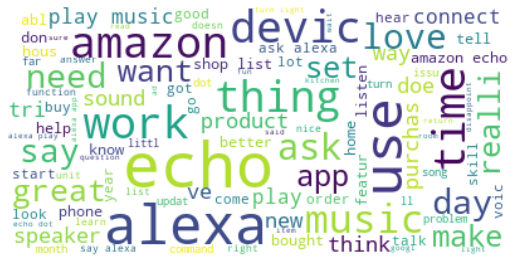

In [22]:
rev = ' '.join(dt['Processed Reviews'])
    
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(rev)
plt.figure(figsize=(9,9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


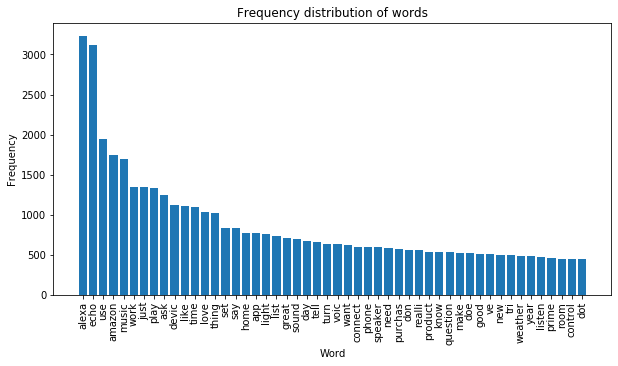

In [23]:
vectorizer = CountVectorizer()
vect_texts = vectorizer.fit_transform(list(dt['Processed Reviews']))
all_ngrams = vectorizer.get_feature_names()
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

plt.figure(figsize=(10, 5))
plt.bar(idx, counts, width=0.8)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Frequency distribution of words')
plt.xticks(idx, ngrams, rotation=90)
plt.show()

# 3- Vectorization and model creation

In [25]:
reviews = dt['Processed Reviews'].values.tolist()
labels = dt['Review Rating'].values.tolist()

In [26]:
set(labels)

{'Negative', 'Positive'}

In [27]:
# to categorical
for i in range(len(labels)):
    if labels[i] == 'Negative':
        labels[i] = 0
    else:
        labels[i] = 1

In [28]:
X_train, X_test, y_train, y_test = tts(reviews, labels, test_size = 0.2)

In [30]:
# creating a tf_idf vectorizer model:
tfidf_vectorizer = TfidfVectorizer(max_features = 1000)
#fittig the tf_idf model with train data:
tfidf_vectorizer.fit(X_train)

TfidfVectorizer(max_features=1000)

In [31]:
X_train = tfidf_vectorizer.transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

In [32]:
# logistic regression evaluation function taken from previous project
    
def metrics(goods, preds):
    print('Accuracy: %.3f' % (accuracy_score(goods, preds)))
    print('Precision: %.3f' % (precision_score(goods, preds)))
    print('Recall: %.3f' % (recall_score(goods, preds)))
    print('F1-Score: %.3f' % (f1_score(goods, preds)))
    
def evaluation(model, Xtst=X_test, ytst=y_test):
    y_pred = model.predict(Xtst)
    cm = confusion_matrix(ytst, y_pred)
    print('******Evaluating Model**********')
    print()
    metrics(ytst, y_pred)
    
    plt.figure(figsize=(20,8))
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap='YlGnBu', fmt='g')
    plt.ylabel('Original')
    plt.xlabel('Prediction')
    plt.title('Confusion Matrix')
    plt.show()
    y_pred_prob = model.predict_proba(Xtst)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    
    plt.figure(figsize=(20,8))#perfect
    plt.plot(precision, recall)
    plt.xlabel('Recall') #recall = truePositive /(truePositive + FalseNeg)
    plt.ylabel('Precision') #precision = TP / (TP + FalsePositive)
    plt.title('Precision Recall Curve') #similar to auc-roc curve
    plt.show()
    #f1_score will be our way to detect the true accuracy of our models
    #f1_score = 2*(Precision*recall)/(precision+recall)
    #         = TP/(TP + 0.5(FP+FN))
    
    Fpr, Tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(Fpr, Tpr)
    plt.figure(figsize=(20,8))
    plt.plot(Fpr, Tpr, color='red', label='AUC = %.5f' % roc_auc)
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    plt.show()
    
    return f1_score(ytst, y_pred), roc_auc

In [33]:
# gridsearch for best params for model
param_grid = {
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : [1.0, 5.0, 10.0, 50.0]
}

logreg = LogisticRegression(random_state = 3)
grid_search = GSCV(estimator=logreg, param_grid=param_grid, cv=10, verbose=3 )
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 80 candidates, totalling 800 fits
[CV 1/10] END C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/10] END C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/10] END C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/10] END C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/10] END C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 6/10] END C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 7/10] END C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 8/10] END C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 9/10] END C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 10/10] END C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/10] END ....C=1.0, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/10] END ....C=1.0, penalty=l1, solver=l

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END ...C=1.0, penalty=l1, solver=saga;, score=0.912 total time=   0.4s
[CV 2/10] END ...C=1.0, penalty=l1, solver=saga;, score=0.931 total time=   0.1s
[CV 3/10] END ...C=1.0, penalty=l1, solver=saga;, score=0.938 total time=   0.1s
[CV 4/10] END ...C=1.0, penalty=l1, solver=saga;, score=0.912 total time=   0.1s
[CV 5/10] END ...C=1.0, penalty=l1, solver=saga;, score=0.900 total time=   0.1s
[CV 6/10] END ...C=1.0, penalty=l1, solver=saga;, score=0.912 total time=   0.2s
[CV 7/10] END ...C=1.0, penalty=l1, solver=saga;, score=0.875 total time=   0.1s
[CV 8/10] END ...C=1.0, penalty=l1, solver=saga;, score=0.912 total time=   0.2s
[CV 9/10] END ...C=1.0, penalty=l1, solver=saga;, score=0.919 total time=   0.2s
[CV 10/10] END ..C=1.0, penalty=l1, solver=saga;, score=0.906 total time=   0.3s
[CV 1/10] END C=1.0, penalty=l2, solver=newton-cg;, score=0.950 total time=   0.1s
[CV 2/10] END C=1.0, penalty=l2, solver=newton-cg;, score=0.938 total time=   0.0s
[CV 3/10] END C=1.0, pen

[CV 1/10] END C=1.0, penalty=none, solver=newton-cg;, score=0.912 total time=   0.0s
[CV 2/10] END C=1.0, penalty=none, solver=newton-cg;, score=0.950 total time=   0.1s
[CV 3/10] END C=1.0, penalty=none, solver=newton-cg;, score=0.963 total time=   0.0s
[CV 4/10] END C=1.0, penalty=none, solver=newton-cg;, score=0.938 total time=   0.0s
[CV 5/10] END C=1.0, penalty=none, solver=newton-cg;, score=0.919 total time=   0.0s
[CV 6/10] END C=1.0, penalty=none, solver=newton-cg;, score=0.931 total time=   0.0s
[CV 7/10] END C=1.0, penalty=none, solver=newton-cg;, score=0.875 total time=   0.0s
[CV 8/10] END C=1.0, penalty=none, solver=newton-cg;, score=0.938 total time=   0.0s
[CV 9/10] END C=1.0, penalty=none, solver=newton-cg;, score=0.969 total time=   0.0s
[CV 10/10] END C=1.0, penalty=none, solver=newton-cg;, score=0.931 total time=   0.0s
[CV 1/10] END C=1.0, penalty=none, solver=lbfgs;, score=0.912 total time=   0.0s
[CV 2/10] END C=1.0, penalty=none, solver=lbfgs;, score=0.950 total 

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END ..C=1.0, penalty=none, solver=sag;, score=0.900 total time=   0.1s
[CV 2/10] END ..C=1.0, penalty=none, solver=sag;, score=0.938 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END ..C=1.0, penalty=none, solver=sag;, score=0.969 total time=   0.0s
[CV 4/10] END ..C=1.0, penalty=none, solver=sag;, score=0.956 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END ..C=1.0, penalty=none, solver=sag;, score=0.956 total time=   0.0s
[CV 6/10] END ..C=1.0, penalty=none, solver=sag;, score=0.938 total time=   0.1s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END ..C=1.0, penalty=none, solver=sag;, score=0.900 total time=   0.1s
[CV 8/10] END ..C=1.0, penalty=none, solver=sag;, score=0.950 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END ..C=1.0, penalty=none, solver=sag;, score=0.956 total time=   0.1s
[CV 10/10] END .C=1.0, penalty=none, solver=sag;, score=0.912 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END .C=1.0, penalty=none, solver=saga;, score=0.906 total time=   0.1s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END .C=1.0, penalty=none, solver=saga;, score=0.931 total time=   0.1s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END .C=1.0, penalty=none, solver=saga;, score=0.969 total time=   0.1s
[CV 4/10] END .C=1.0, penalty=none, solver=saga;, score=0.963 total time=   0.1s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END .C=1.0, penalty=none, solver=saga;, score=0.956 total time=   0.1s
[CV 6/10] END .C=1.0, penalty=none, solver=saga;, score=0.944 total time=   0.1s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END .C=1.0, penalty=none, solver=saga;, score=0.894 total time=   0.1s
[CV 8/10] END .C=1.0, penalty=none, solver=saga;, score=0.950 total time=   0.1s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END .C=1.0, penalty=none, solver=saga;, score=0.963 total time=   0.0s
[CV 10/10] END C=1.0, penalty=none, solver=saga;, score=0.919 total time=   0.0s
[CV 1/10] END C=5.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/10] END C=5.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/10] END C=5.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/10] END C=5.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/10] END C=5.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 6/10] END C=5.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 7/10] END C=5.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 8/10] END C=5.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 9/10] END C=5.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 10/10] END C=5.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/10] END ....C=5.0, pe

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END ...C=5.0, penalty=l1, solver=saga;, score=0.925 total time=   0.3s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END ...C=5.0, penalty=l1, solver=saga;, score=0.938 total time=   0.3s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END ...C=5.0, penalty=l1, solver=saga;, score=0.956 total time=   0.4s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END ...C=5.0, penalty=l1, solver=saga;, score=0.931 total time=   0.4s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END ...C=5.0, penalty=l1, solver=saga;, score=0.938 total time=   0.4s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END ...C=5.0, penalty=l1, solver=saga;, score=0.944 total time=   0.3s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END ...C=5.0, penalty=l1, solver=saga;, score=0.894 total time=   0.4s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END ...C=5.0, penalty=l1, solver=saga;, score=0.938 total time=   0.4s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END ...C=5.0, penalty=l1, solver=saga;, score=0.944 total time=   0.4s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END ..C=5.0, penalty=l1, solver=saga;, score=0.925 total time=   0.3s
[CV 1/10] END C=5.0, penalty=l2, solver=newton-cg;, score=0.925 total time=   0.0s
[CV 2/10] END C=5.0, penalty=l2, solver=newton-cg;, score=0.950 total time=   0.0s
[CV 3/10] END C=5.0, penalty=l2, solver=newton-cg;, score=0.981 total time=   0.0s
[CV 4/10] END C=5.0, penalty=l2, solver=newton-cg;, score=0.950 total time=   0.0s
[CV 5/10] END C=5.0, penalty=l2, solver=newton-cg;, score=0.963 total time=   0.0s
[CV 6/10] END C=5.0, penalty=l2, solver=newton-cg;, score=0.931 total time=   0.0s
[CV 7/10] END C=5.0, penalty=l2, solver=newton-cg;, score=0.925 total time=   0.0s
[CV 8/10] END C=5.0, penalty=l2, solver=newton-cg;, score=0.956 total time=   0.0s
[CV 9/10] END C=5.0, penalty=l2, solver=newton-cg;, score=0.981 total time=   0.0s
[CV 10/10] END C=5.0, penalty=l2, solver=newton-cg;, score=0.931 total time=   0.0s
[CV 1/10] END ..C=5.0, penalty=l2, solver=lbfgs;, score=0.925 total time=   0.0s
[CV 2/1

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END ...C=5.0, penalty=l2, solver=saga;, score=0.925 total time=   0.0s
[CV 2/10] END ...C=5.0, penalty=l2, solver=saga;, score=0.950 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END ...C=5.0, penalty=l2, solver=saga;, score=0.981 total time=   0.1s
[CV 4/10] END ...C=5.0, penalty=l2, solver=saga;, score=0.956 total time=   0.1s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END ...C=5.0, penalty=l2, solver=saga;, score=0.963 total time=   0.0s
[CV 6/10] END ...C=5.0, penalty=l2, solver=saga;, score=0.931 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END ...C=5.0, penalty=l2, solver=saga;, score=0.925 total time=   0.0s
[CV 8/10] END ...C=5.0, penalty=l2, solver=saga;, score=0.963 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END ...C=5.0, penalty=l2, solver=saga;, score=0.981 total time=   0.0s
[CV 10/10] END ..C=5.0, penalty=l2, solver=saga;, score=0.931 total time=   0.0s
[CV 1/10] END C=5.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/10] END C=5.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/10] END C=5.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/10] END C=5.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/10] END C=5.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 6/10] END C=5.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 7/10] END C=5.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 8/10] END C=5.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 9/10] END C=5.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 10/10] END C=5.0, penalty=elastic

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 2/10] END C=5.0, penalty=none, solver=newton-cg;, score=0.950 total time=   0.0s
[CV 3/10] END C=5.0, penalty=none, solver=newton-cg;, score=0.963 total time=   0.0s
[CV 4/10] END C=5.0, penalty=none, solver=newton-cg;, score=0.938 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 5/10] END C=5.0, penalty=none, solver=newton-cg;, score=0.919 total time=   0.0s
[CV 6/10] END C=5.0, penalty=none, solver=newton-cg;, score=0.931 total time=   0.0s
[CV 7/10] END C=5.0, penalty=none, solver=newton-cg;, score=0.875 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 8/10] END C=5.0, penalty=none, solver=newton-cg;, score=0.938 total time=   0.0s
[CV 9/10] END C=5.0, penalty=none, solver=newton-cg;, score=0.969 total time=   0.0s
[CV 10/10] END C=5.0, penalty=none, solver=newton-cg;, score=0.931 total time=   0.0s
[CV 1/10] END C=5.0, penalty=none, solver=lbfgs;, score=0.912 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning:

[CV 2/10] END C=5.0, penalty=none, solver=lbfgs;, score=0.950 total time=   0.0s
[CV 3/10] END C=5.0, penalty=none, solver=lbfgs;, score=0.956 total time=   0.0s
[CV 4/10] END C=5.0, penalty=none, solver=lbfgs;, score=0.950 total time=   0.0s
[CV 5/10] END C=5.0, penalty=none, solver=lbfgs;, score=0.925 total time=   0.0s
[CV 6/10] END C=5.0, penalty=none, solver=lbfgs;, score=0.944 total time=   0.0s
[CV 7/10] END C=5.0, penalty=none, solver=lbfgs;, score=0.869 total time=   0.0s
[CV 8/10] END C=5.0, penalty=none, solver=lbfgs;, score=0.931 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning:

[CV 9/10] END C=5.0, penalty=none, solver=lbfgs;, score=0.950 total time=   0.0s
[CV 10/10] END C=5.0, penalty=none, solver=lbfgs;, score=0.938 total time=   0.0s
[CV 1/10] END C=5.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/10] END C=5.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/10] END C=5.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/10] END C=5.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/10] END C=5.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 6/10] END C=5.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 7/10] END C=5.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 8/10] END C=5.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 9/10] END C=5.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 10/10] END C=5.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 1/

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' wi

[CV 2/10] END ..C=5.0, penalty=none, solver=sag;, score=0.938 total time=   0.0s
[CV 3/10] END ..C=5.0, penalty=none, solver=sag;, score=0.969 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 4/10] END ..C=5.0, penalty=none, solver=sag;, score=0.956 total time=   0.0s
[CV 5/10] END ..C=5.0, penalty=none, solver=sag;, score=0.956 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END ..C=5.0, penalty=none, solver=sag;, score=0.938 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 7/10] END ..C=5.0, penalty=none, solver=sag;, score=0.900 total time=   0.1s
[CV 8/10] END ..C=5.0, penalty=none, solver=sag;, score=0.950 total time=   0.1s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 9/10] END ..C=5.0, penalty=none, solver=sag;, score=0.956 total time=   0.0s
[CV 10/10] END .C=5.0, penalty=none, solver=sag;, score=0.912 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 1/10] END .C=5.0, penalty=none, solver=saga;, score=0.906 total time=   0.1s
[CV 2/10] END .C=5.0, penalty=none, solver=saga;, score=0.931 total time=   0.1s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 3/10] END .C=5.0, penalty=none, solver=saga;, score=0.969 total time=   0.1s
[CV 4/10] END .C=5.0, penalty=none, solver=saga;, score=0.963 total time=   0.1s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 5/10] END .C=5.0, penalty=none, solver=saga;, score=0.956 total time=   0.0s
[CV 6/10] END .C=5.0, penalty=none, solver=saga;, score=0.944 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 7/10] END .C=5.0, penalty=none, solver=saga;, score=0.894 total time=   0.0s
[CV 8/10] END .C=5.0, penalty=none, solver=saga;, score=0.950 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END .C=5.0, penalty=none, solver=saga;, score=0.963 total time=   0.1s
[CV 10/10] END C=5.0, penalty=none, solver=saga;, score=0.919 total time=   0.0s
[CV 1/10] END C=10.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/10] END C=10.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/10] END C=10.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/10] END C=10.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/10] END C=10.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 6/10] END C=10.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 7/10] END C=10.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 8/10] END C=10.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 9/10] END C=10.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 10/10] END C=10.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/10] END ...

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END ..C=10.0, penalty=l1, solver=saga;, score=0.919 total time=   0.4s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END ..C=10.0, penalty=l1, solver=saga;, score=0.931 total time=   0.4s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END ..C=10.0, penalty=l1, solver=saga;, score=0.950 total time=   0.4s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END ..C=10.0, penalty=l1, solver=saga;, score=0.944 total time=   0.4s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END ..C=10.0, penalty=l1, solver=saga;, score=0.944 total time=   0.4s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END ..C=10.0, penalty=l1, solver=saga;, score=0.938 total time=   0.5s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END ..C=10.0, penalty=l1, solver=saga;, score=0.900 total time=   0.5s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END ..C=10.0, penalty=l1, solver=saga;, score=0.950 total time=   0.4s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END ..C=10.0, penalty=l1, solver=saga;, score=0.944 total time=   0.5s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END .C=10.0, penalty=l1, solver=saga;, score=0.925 total time=   0.4s
[CV 1/10] END C=10.0, penalty=l2, solver=newton-cg;, score=0.919 total time=   0.0s
[CV 2/10] END C=10.0, penalty=l2, solver=newton-cg;, score=0.956 total time=   0.0s
[CV 3/10] END C=10.0, penalty=l2, solver=newton-cg;, score=0.988 total time=   0.0s
[CV 4/10] END C=10.0, penalty=l2, solver=newton-cg;, score=0.956 total time=   0.0s
[CV 5/10] END C=10.0, penalty=l2, solver=newton-cg;, score=0.963 total time=   0.0s
[CV 6/10] END C=10.0, penalty=l2, solver=newton-cg;, score=0.944 total time=   0.0s
[CV 7/10] END C=10.0, penalty=l2, solver=newton-cg;, score=0.900 total time=   0.0s
[CV 8/10] END C=10.0, penalty=l2, solver=newton-cg;, score=0.963 total time=   0.0s
[CV 9/10] END C=10.0, penalty=l2, solver=newton-cg;, score=0.975 total time=   0.0s
[CV 10/10] END C=10.0, penalty=l2, solver=newton-cg;, score=0.931 total time=   0.0s
[CV 1/10] END .C=10.0, penalty=l2, solver=lbfgs;, score=0.919 total time=   0.

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END ..C=10.0, penalty=l2, solver=saga;, score=0.912 total time=   0.1s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END ..C=10.0, penalty=l2, solver=saga;, score=0.956 total time=   0.1s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END ..C=10.0, penalty=l2, solver=saga;, score=0.988 total time=   0.1s
[CV 4/10] END ..C=10.0, penalty=l2, solver=saga;, score=0.956 total time=   0.1s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END ..C=10.0, penalty=l2, solver=saga;, score=0.969 total time=   0.1s
[CV 6/10] END ..C=10.0, penalty=l2, solver=saga;, score=0.944 total time=   0.1s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END ..C=10.0, penalty=l2, solver=saga;, score=0.906 total time=   0.1s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END ..C=10.0, penalty=l2, solver=saga;, score=0.963 total time=   0.1s
[CV 9/10] END ..C=10.0, penalty=l2, solver=saga;, score=0.975 total time=   0.1s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END .C=10.0, penalty=l2, solver=saga;, score=0.931 total time=   0.1s
[CV 1/10] END C=10.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/10] END C=10.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/10] END C=10.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/10] END C=10.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/10] END C=10.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 6/10] END C=10.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 7/10] END C=10.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 8/10] END C=10.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 9/10] END C=10.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 10/10] END C=10.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/10] END C=10

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 3/10] END C=10.0, penalty=none, solver=newton-cg;, score=0.963 total time=   0.0s
[CV 4/10] END C=10.0, penalty=none, solver=newton-cg;, score=0.938 total time=   0.0s
[CV 5/10] END C=10.0, penalty=none, solver=newton-cg;, score=0.919 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 6/10] END C=10.0, penalty=none, solver=newton-cg;, score=0.931 total time=   0.0s
[CV 7/10] END C=10.0, penalty=none, solver=newton-cg;, score=0.875 total time=   0.0s
[CV 8/10] END C=10.0, penalty=none, solver=newton-cg;, score=0.938 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 9/10] END C=10.0, penalty=none, solver=newton-cg;, score=0.969 total time=   0.0s
[CV 10/10] END C=10.0, penalty=none, solver=newton-cg;, score=0.931 total time=   0.0s
[CV 1/10] END C=10.0, penalty=none, solver=lbfgs;, score=0.912 total time=   0.0s
[CV 2/10] END C=10.0, penalty=none, solver=lbfgs;, score=0.950 total time=   0.0s
[CV 3/10] END C=10.0, penalty=none, solver=lbfgs;, score=0.956 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning:

[CV 4/10] END C=10.0, penalty=none, solver=lbfgs;, score=0.950 total time=   0.0s
[CV 5/10] END C=10.0, penalty=none, solver=lbfgs;, score=0.925 total time=   0.0s
[CV 6/10] END C=10.0, penalty=none, solver=lbfgs;, score=0.944 total time=   0.0s
[CV 7/10] END C=10.0, penalty=none, solver=lbfgs;, score=0.869 total time=   0.0s
[CV 8/10] END C=10.0, penalty=none, solver=lbfgs;, score=0.931 total time=   0.0s
[CV 9/10] END C=10.0, penalty=none, solver=lbfgs;, score=0.950 total time=   0.0s
[CV 10/10] END C=10.0, penalty=none, solver=lbfgs;, score=0.938 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END C=10.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/10] END C=10.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/10] END C=10.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/10] END C=10.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/10] END C=10.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 6/10] END C=10.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 7/10] END C=10.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 8/10] END C=10.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 9/10] END C=10.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 10/10] END C=10.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 1/10] END .C=10.0, penalty=none, solver=sag;, score=0.900 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 2/10] END .C=10.0, penalty=none, solver=sag;, score=0.938 total time=   0.0s
[CV 3/10] END .C=10.0, penalty=none, solver=sag;, score=0.969 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 4/10] END .C=10.0, penalty=none, solver=sag;, score=0.956 total time=   0.0s
[CV 5/10] END .C=10.0, penalty=none, solver=sag;, score=0.956 total time=   0.1s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 6/10] END .C=10.0, penalty=none, solver=sag;, score=0.938 total time=   0.0s
[CV 7/10] END .C=10.0, penalty=none, solver=sag;, score=0.900 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 8/10] END .C=10.0, penalty=none, solver=sag;, score=0.950 total time=   0.0s
[CV 9/10] END .C=10.0, penalty=none, solver=sag;, score=0.956 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 10/10] END C=10.0, penalty=none, solver=sag;, score=0.912 total time=   0.0s
[CV 1/10] END C=10.0, penalty=none, solver=saga;, score=0.906 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END C=10.0, penalty=none, solver=saga;, score=0.931 total time=   0.1s
[CV 3/10] END C=10.0, penalty=none, solver=saga;, score=0.969 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' wi

[CV 4/10] END C=10.0, penalty=none, solver=saga;, score=0.963 total time=   0.0s
[CV 5/10] END C=10.0, penalty=none, solver=saga;, score=0.956 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 6/10] END C=10.0, penalty=none, solver=saga;, score=0.944 total time=   0.1s
[CV 7/10] END C=10.0, penalty=none, solver=saga;, score=0.894 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 8/10] END C=10.0, penalty=none, solver=saga;, score=0.950 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END C=10.0, penalty=none, solver=saga;, score=0.963 total time=   0.1s
[CV 10/10] END C=10.0, penalty=none, solver=saga;, score=0.919 total time=   0.1s
[CV 1/10] END C=50.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/10] END C=50.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/10] END C=50.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/10] END C=50.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/10] END C=50.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 6/10] END C=50.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 7/10] END C=50.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 8/10] END C=50.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 9/10] END C=50.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 10/10] END C=50.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/10] END ..

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END ..C=50.0, penalty=l1, solver=saga;, score=0.919 total time=   0.7s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END ..C=50.0, penalty=l1, solver=saga;, score=0.938 total time=   0.6s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END ..C=50.0, penalty=l1, solver=saga;, score=0.963 total time=   0.6s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END ..C=50.0, penalty=l1, solver=saga;, score=0.944 total time=   0.6s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END ..C=50.0, penalty=l1, solver=saga;, score=0.956 total time=   0.6s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END ..C=50.0, penalty=l1, solver=saga;, score=0.931 total time=   0.6s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END ..C=50.0, penalty=l1, solver=saga;, score=0.881 total time=   0.6s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END ..C=50.0, penalty=l1, solver=saga;, score=0.969 total time=   0.6s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END ..C=50.0, penalty=l1, solver=saga;, score=0.975 total time=   0.6s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END .C=50.0, penalty=l1, solver=saga;, score=0.931 total time=   0.6s
[CV 1/10] END C=50.0, penalty=l2, solver=newton-cg;, score=0.906 total time=   0.0s
[CV 2/10] END C=50.0, penalty=l2, solver=newton-cg;, score=0.956 total time=   0.0s
[CV 3/10] END C=50.0, penalty=l2, solver=newton-cg;, score=0.975 total time=   0.0s
[CV 4/10] END C=50.0, penalty=l2, solver=newton-cg;, score=0.950 total time=   0.0s
[CV 5/10] END C=50.0, penalty=l2, solver=newton-cg;, score=0.956 total time=   0.0s
[CV 6/10] END C=50.0, penalty=l2, solver=newton-cg;, score=0.944 total time=   0.0s
[CV 7/10] END C=50.0, penalty=l2, solver=newton-cg;, score=0.894 total time=   0.0s
[CV 8/10] END C=50.0, penalty=l2, solver=newton-cg;, score=0.969 total time=   0.0s
[CV 9/10] END C=50.0, penalty=l2, solver=newton-cg;, score=0.975 total time=   0.0s
[CV 10/10] END C=50.0, penalty=l2, solver=newton-cg;, score=0.931 total time=   0.0s
[CV 1/10] END .C=50.0, penalty=l2, solver=lbfgs;, score=0.906 total time=   0.

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END ...C=50.0, penalty=l2, solver=sag;, score=0.906 total time=   0.0s
[CV 2/10] END ...C=50.0, penalty=l2, solver=sag;, score=0.956 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END ...C=50.0, penalty=l2, solver=sag;, score=0.969 total time=   0.0s
[CV 4/10] END ...C=50.0, penalty=l2, solver=sag;, score=0.956 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END ...C=50.0, penalty=l2, solver=sag;, score=0.956 total time=   0.1s
[CV 6/10] END ...C=50.0, penalty=l2, solver=sag;, score=0.944 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END ...C=50.0, penalty=l2, solver=sag;, score=0.887 total time=   0.0s
[CV 8/10] END ...C=50.0, penalty=l2, solver=sag;, score=0.969 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END ...C=50.0, penalty=l2, solver=sag;, score=0.975 total time=   0.0s
[CV 10/10] END ..C=50.0, penalty=l2, solver=sag;, score=0.931 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END ..C=50.0, penalty=l2, solver=saga;, score=0.906 total time=   0.1s
[CV 2/10] END ..C=50.0, penalty=l2, solver=saga;, score=0.950 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END ..C=50.0, penalty=l2, solver=saga;, score=0.969 total time=   0.0s
[CV 4/10] END ..C=50.0, penalty=l2, solver=saga;, score=0.956 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END ..C=50.0, penalty=l2, solver=saga;, score=0.956 total time=   0.0s
[CV 6/10] END ..C=50.0, penalty=l2, solver=saga;, score=0.944 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END ..C=50.0, penalty=l2, solver=saga;, score=0.894 total time=   0.0s
[CV 8/10] END ..C=50.0, penalty=l2, solver=saga;, score=0.969 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END ..C=50.0, penalty=l2, solver=saga;, score=0.975 total time=   0.0s
[CV 10/10] END .C=50.0, penalty=l2, solver=saga;, score=0.938 total time=   0.0s
[CV 1/10] END C=50.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/10] END C=50.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/10] END C=50.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/10] END C=50.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/10] END C=50.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 6/10] END C=50.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 7/10] END C=50.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 8/10] END C=50.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 9/10] END C=50.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 10/10] END C=50.0, penal

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 2/10] END C=50.0, penalty=none, solver=newton-cg;, score=0.950 total time=   0.0s
[CV 3/10] END C=50.0, penalty=none, solver=newton-cg;, score=0.963 total time=   0.0s
[CV 4/10] END C=50.0, penalty=none, solver=newton-cg;, score=0.938 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 5/10] END C=50.0, penalty=none, solver=newton-cg;, score=0.919 total time=   0.0s
[CV 6/10] END C=50.0, penalty=none, solver=newton-cg;, score=0.931 total time=   0.0s
[CV 7/10] END C=50.0, penalty=none, solver=newton-cg;, score=0.875 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 8/10] END C=50.0, penalty=none, solver=newton-cg;, score=0.938 total time=   0.0s
[CV 9/10] END C=50.0, penalty=none, solver=newton-cg;, score=0.969 total time=   0.0s
[CV 10/10] END C=50.0, penalty=none, solver=newton-cg;, score=0.931 total time=   0.0s
[CV 1/10] END C=50.0, penalty=none, solver=lbfgs;, score=0.912 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning:

[CV 2/10] END C=50.0, penalty=none, solver=lbfgs;, score=0.950 total time=   0.0s
[CV 3/10] END C=50.0, penalty=none, solver=lbfgs;, score=0.956 total time=   0.0s
[CV 4/10] END C=50.0, penalty=none, solver=lbfgs;, score=0.950 total time=   0.0s
[CV 5/10] END C=50.0, penalty=none, solver=lbfgs;, score=0.925 total time=   0.0s
[CV 6/10] END C=50.0, penalty=none, solver=lbfgs;, score=0.944 total time=   0.0s
[CV 7/10] END C=50.0, penalty=none, solver=lbfgs;, score=0.869 total time=   0.0s
[CV 8/10] END C=50.0, penalty=none, solver=lbfgs;, score=0.931 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning:

[CV 9/10] END C=50.0, penalty=none, solver=lbfgs;, score=0.950 total time=   0.0s
[CV 10/10] END C=50.0, penalty=none, solver=lbfgs;, score=0.938 total time=   0.0s
[CV 1/10] END C=50.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/10] END C=50.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/10] END C=50.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/10] END C=50.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/10] END C=50.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 6/10] END C=50.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 7/10] END C=50.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 8/10] END C=50.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 9/10] END C=50.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 10/10] END C=50.0, penalty=none, solver=liblinear;, score=nan total time=  

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' wi

[CV 2/10] END .C=50.0, penalty=none, solver=sag;, score=0.938 total time=   0.0s
[CV 3/10] END .C=50.0, penalty=none, solver=sag;, score=0.969 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 4/10] END .C=50.0, penalty=none, solver=sag;, score=0.956 total time=   0.0s
[CV 5/10] END .C=50.0, penalty=none, solver=sag;, score=0.956 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 6/10] END .C=50.0, penalty=none, solver=sag;, score=0.938 total time=   0.0s
[CV 7/10] END .C=50.0, penalty=none, solver=sag;, score=0.900 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 8/10] END .C=50.0, penalty=none, solver=sag;, score=0.950 total time=   0.0s
[CV 9/10] END .C=50.0, penalty=none, solver=sag;, score=0.956 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 10/10] END C=50.0, penalty=none, solver=sag;, score=0.912 total time=   0.0s
[CV 1/10] END C=50.0, penalty=none, solver=saga;, score=0.906 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 2/10] END C=50.0, penalty=none, solver=saga;, score=0.931 total time=   0.0s
[CV 3/10] END C=50.0, penalty=none, solver=saga;, score=0.969 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 4/10] END C=50.0, penalty=none, solver=saga;, score=0.963 total time=   0.0s
[CV 5/10] END C=50.0, penalty=none, solver=saga;, score=0.956 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 6/10] END C=50.0, penalty=none, solver=saga;, score=0.944 total time=   0.0s
[CV 7/10] END C=50.0, penalty=none, solver=saga;, score=0.894 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 8/10] END C=50.0, penalty=none, solver=saga;, score=0.950 total time=   0.0s
[CV 9/10] END C=50.0, penalty=none, solver=saga;, score=0.963 total time=   0.0s
[CV 10/10] END C=50.0, penalty=none, solver=saga;, score=0.919 total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
360 fits failed out of a total of 800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=3),
             param_grid={'C': [1.0, 5.0, 10.0, 50.0],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             verbose=3)

In [34]:
lr_best_params = grid_search.best_params_
lr_best_params

{'C': 5.0, 'penalty': 'l2', 'solver': 'liblinear'}

******Evaluating Model**********

Accuracy: 0.935
Precision: 0.925
Recall: 0.944
F1-Score: 0.935


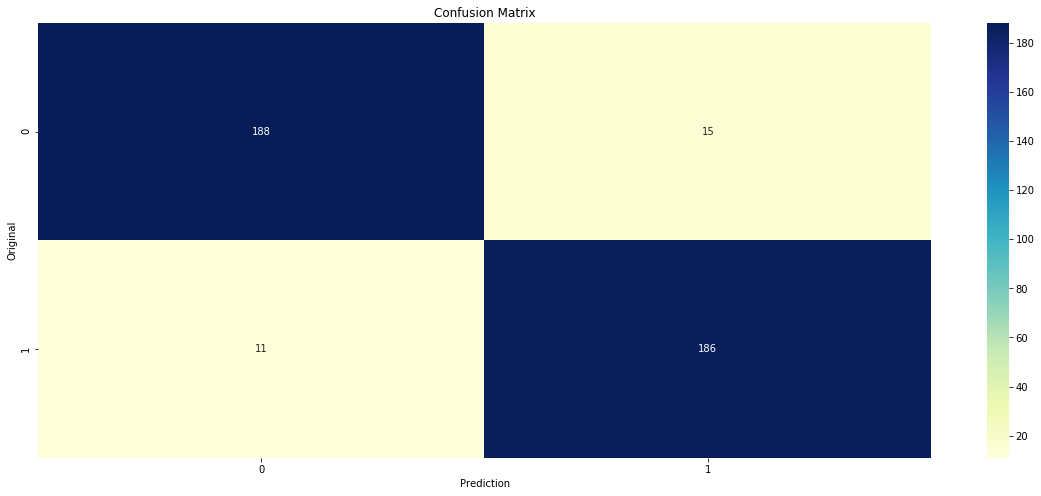

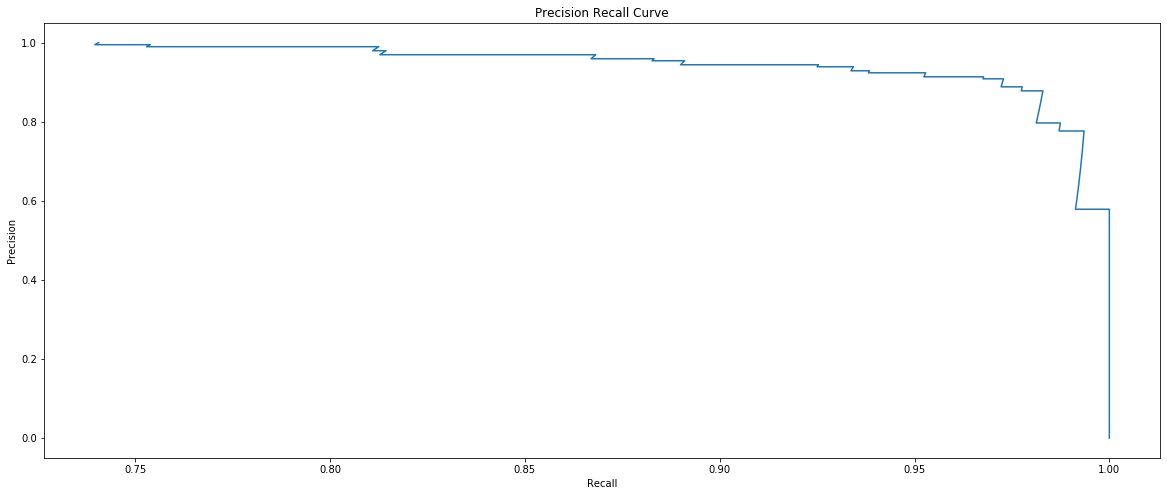

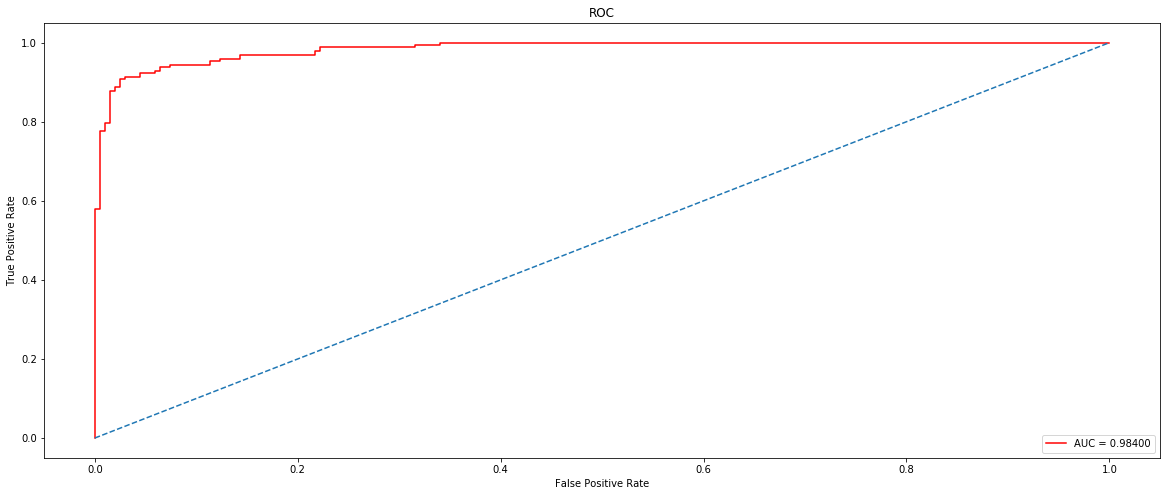

In [35]:
LR = LogisticRegression( C=5.0, solver = 'liblinear', penalty='l2', random_state=3) #best solver for our data (binairy and small)
LR.fit(X_train,y_train)
f1_logreg_nosmote, auc_logreg_nosmote = evaluation(LR)